# Analysis of Clusters - OPTICS 2

This is just one of the clusterings. For the others see the 'Cluster Analysis PDFs' folder.

This run of OPTICS used default sklearn parameters with a max epsilon of 0.05 and min samples per cluster of 200. The algorithm used the cosine dissimilarity between document vectors as distance metric. Two clusters were produced, both of similar size. The growth of these wasnt tested with addition of more data. This seemed to be the most promising clustering, although low number of clusters and low max epsilon parameter may be cause for concern.

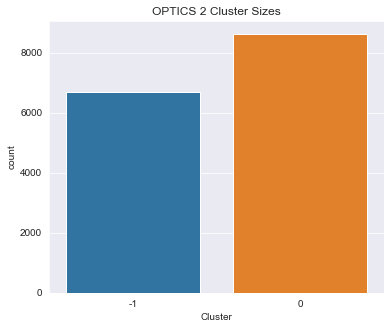

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from nrclex import NRCLex
from ast import literal_eval
from wordcloud import WordCloud
import random
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

df=pd.read_csv('Election_Tweets_Clustered_OPTICS2.csv', index_col=0)
clusters=list(df['Cluster'].unique())
plt.figure(figsize=(6,5))
sns.countplot(data=df, x='Cluster')
plt.title('OPTICS 2 Cluster Sizes');

# Cluster Sentiment

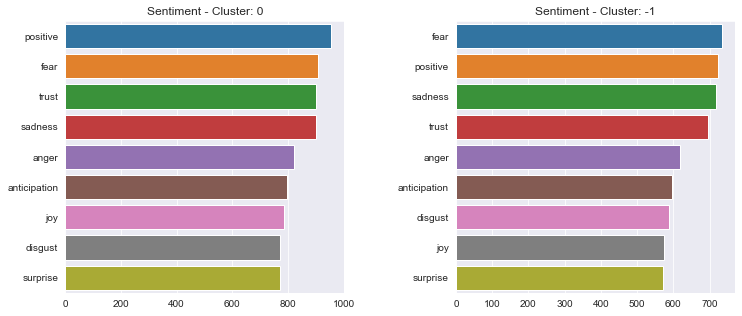

In [9]:
emot_sent=pd.DataFrame(df[['contents','Cluster']].copy(),columns=['contents', 'Cluster'])
list_emots=[]
for idx, tweet in df.iterrows():
    list_emots.append([])
    text_object=NRCLex(tweet.contents)
    for emotion in text_object.affect_frequencies.keys():
        list_emots[idx].append(text_object.affect_frequencies[emotion])
df_emots=pd.DataFrame(list_emots, columns=['fear','anger','anticipation','trust','surprise','positive','negative', 'sadness', 'disgust', 'joy'])
        
emot_sent=emot_sent.join(df_emots)

plt.figure(figsize=(6*len(clusters),5))
plt.subplots_adjust(wspace=0.4)
for clust in clusters:
    emot_sent_clust=emot_sent[emot_sent['Cluster']==clust]
    feelings_clust=emot_sent_clust.sum(axis=0).iloc[2:]
    feelings_clust.sort_values(ascending=False, inplace=True)
    plt.subplot(1, len(clusters), clusters.index(clust)+1)
    sns.barplot(x=feelings_clust.iloc[1:].values, y=feelings_clust.index[1:])
    plt.title('Sentiment - Cluster: '+str(clust))
    

Not a significant difference in ordering identified.

# Cluster Hashtags

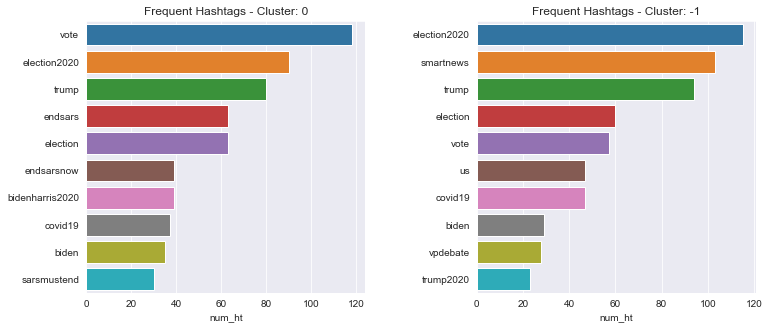

In [3]:
plt.figure(figsize=(6*len(clusters),5))
plt.subplots_adjust(wspace=0.4)
for clust in clusters: 
    df_clust=df[df['Cluster']==clust].copy()
    hashtags_clust=[ht for ht_list in df_clust.hashtag.apply(literal_eval).values for ht in ht_list]
    d_clust=pd.DataFrame.from_dict({ht:hashtags_clust.count(ht) for ht in hashtags_clust}, orient='index', columns=['num_ht'])
    d_clust.sort_values(by='num_ht', ascending=False, inplace=True)
    plt.subplot(1, len(clusters), clusters.index(clust)+1)
    sns.barplot(x=d_clust.iloc[:10].num_ht, y=d_clust.index[:10])
    plt.title('Frequent Hashtags - Cluster: '+str(clust))

It difficult to conclude anything from these, beyond that sars based tweets seem mostly in Cluster 0. It is unclear why so many sars tweets showed up in the scrape (sars hashtags are in support of police brutality protests in Nigeria - it could be linking into the police brutality discussions surrounding the US election).

# Cluster Wordclouds

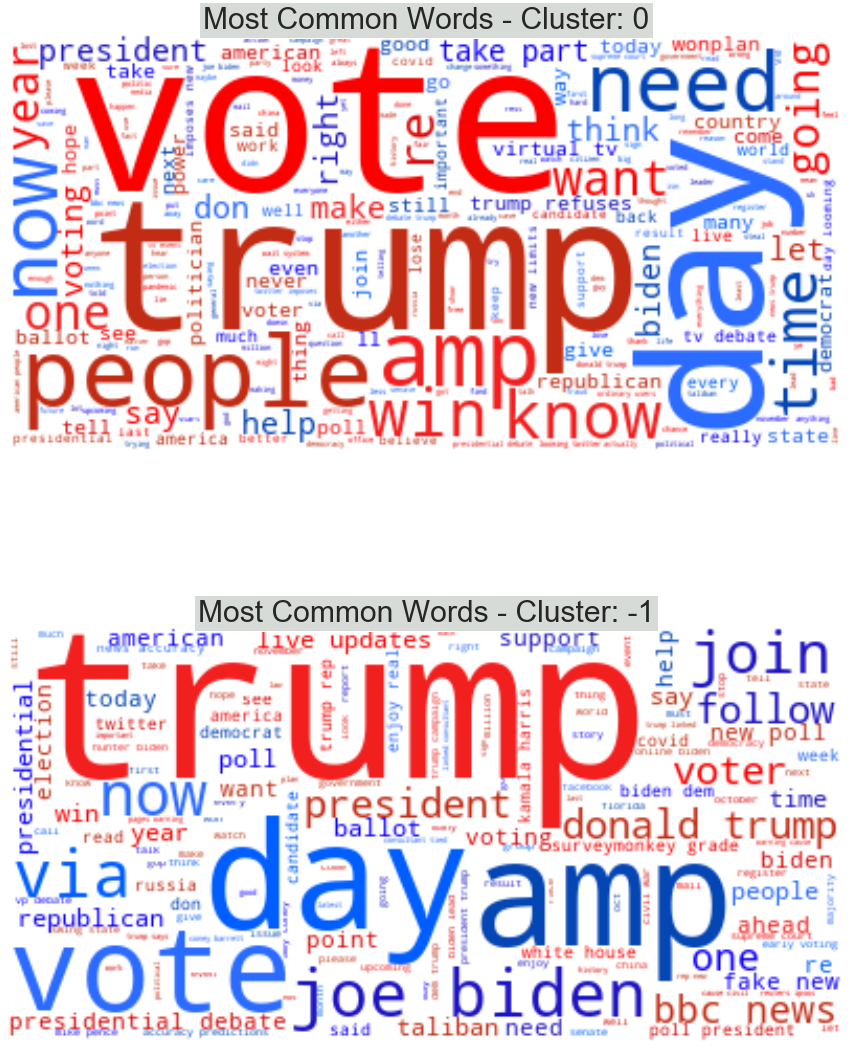

In [11]:
def rb_color(word,font_size,font_path,position,orientation,random_state=None):
    return random.choice(['#f21f1f','#d90b0b','#fc0000','#c22c15','#c23215','#1e15c2','#0d00ff','#005eff','#0546b5','#2b6bff'])

plt.figure(figsize=(15,10*len(clusters)))
for clust in clusters:
    all_clust=" ".join(content for content in list(df[df['Cluster']==clust].contents))
    all_clust=all_clust.replace(' us ',' ')
    all_clust=all_clust.replace(' election ', ' ')
    all_clust=all_clust.replace(' will ', ' ')
    wc_clust=WordCloud(background_color='white', max_font_size=100, max_words=500, random_state=42).generate(all_clust).recolor(color_func=rb_color)
    plt.subplot(len(clusters), 1, clusters.index(clust)+1)
    plt.axis('off')
    plt.imshow(wc_clust, interpolation='bilinear')
    plt.title('Most Common Words - Cluster: '+str(clust), fontdict={'fontsize':30},bbox={'facecolor':'#d7dbd8','ec':'white'})

# Cluster Likes and Retweets

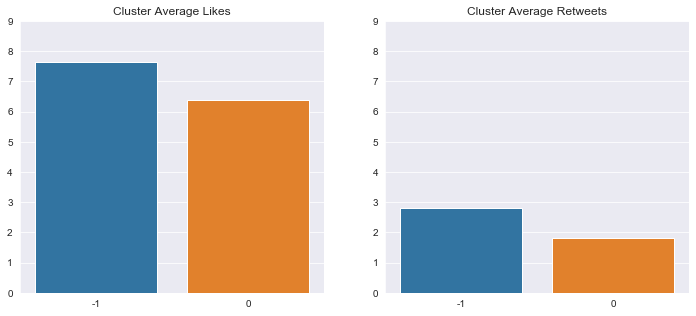

In [14]:
likes, retweets=[],[]
for clust in clusters:
    likes.append(df[df['Cluster']==clust].likes.mean())
    retweets.append(df[df['Cluster']==clust].retweets.mean())
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.ylim(top=int(max(max(likes),max(retweets))+2))
plt.title('Cluster Average Likes')
sns.barplot(x=clusters, y=likes)

plt.subplot(1,2,2)
plt.ylim(top=int(max(max(likes),max(retweets))+2))
plt.title('Cluster Average Retweets')
sns.barplot(x=clusters, y=retweets);

# Cluster Candidate Mentions

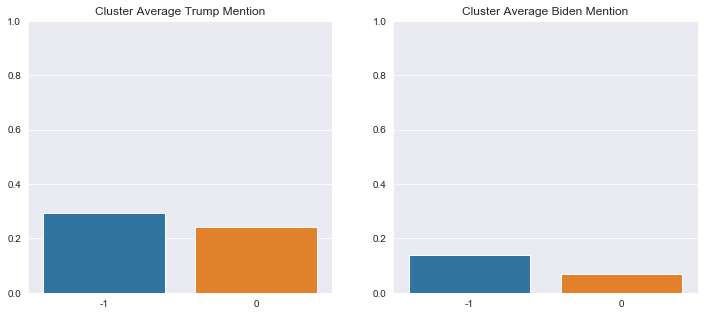

In [15]:
df['trump_mention']=df['contents'].apply(lambda x: int('trump' in x))
df['biden_mention']=df['contents'].apply(lambda x: int('biden' in x))
trump_mentions=[(df[df['Cluster']==clust].trump_mention.sum())/df[df['Cluster']==clust].shape[0] for clust in clusters]
biden_mentions=[(df[df['Cluster']==clust].biden_mention.sum())/df[df['Cluster']==clust].shape[0] for clust in clusters]
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Cluster Average Trump Mention')
plt.ylim(top=1)
sns.barplot(x=clusters, y=trump_mentions)

plt.subplot(1,2,2)
plt.title('Cluster Average Biden Mention')
plt.ylim(top=1)
sns.barplot(x=clusters, y=biden_mentions);

# Cluster Locations

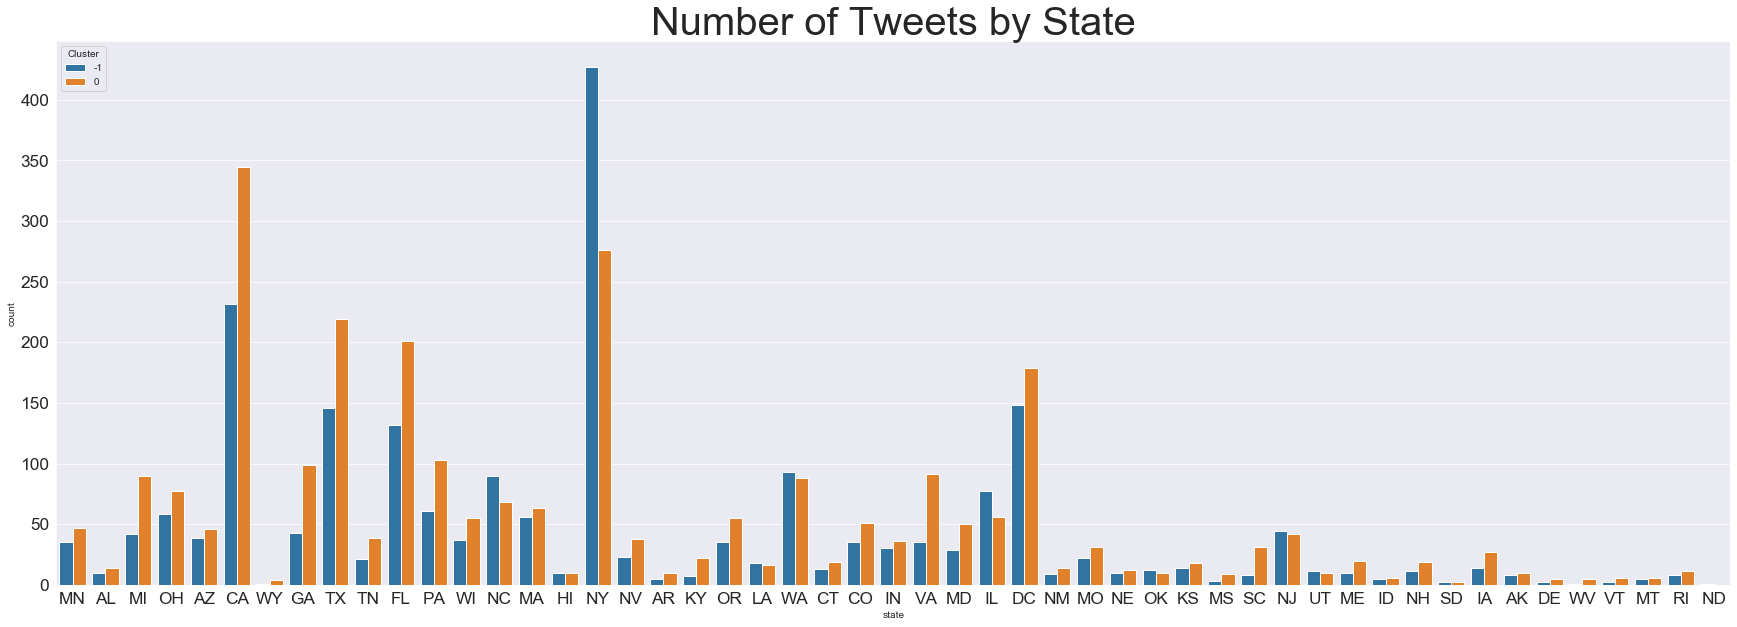

In [7]:
states=['AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME', \
       'MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI',\
       'SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']
states_full=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 
             'District of Columbia','Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 
             'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 
             'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
             'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
             'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 
             'West Virginia', 'Wisconsin', 'Wyoming']

def get_state(place):
    for state in states:
        try:
            if ' '+state in place:
                return state
        except TypeError:
            continue
    for state in states_full:
        try:
            if state in place:
                return states[states_full.index(state)]
        except TypeError:
            continue
    return None

df['state']=df['location'].apply(get_state)
plt.figure(figsize=(30,10))
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.title('Number of Tweets by State', fontsize=40)
sns.countplot(data=df, x='state', hue='Cluster');



# Overall Conclusions

While at the face of it, this looked like a more promising clustering, the clusters seemed to be broadly similar. This is likely a result of such a small max epsilon parameter being chosen, but also due to the general lack of clusterability within the tweets themselves. 